In [ ]:
#gpu

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy

In [2]:
# Carregar dados MNIST
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
# Hiper parâmetros
batch_size = 100
original_dim = 784
latent_dim = 8
intermediate_dim = 256
epochs = 100
epsilon_std = 1.0

In [5]:
# Encoder
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [6]:
# Função para amostrar do espaço latente
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2 ) * epsilon
# Camada de amostragem
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [7]:
# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [8]:
# Loss
xent_loss = original_dim * binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

In [9]:
# Modelo VAE
vae = Model(x, x_decoded_mean)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

In [10]:
# Treinar o VAE
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Epoch 1/100
600/600 [==============================] - 8s 5ms/step - loss: 160.1008 - val_loss: 134.9731
Epoch 2/100
600/600 [==============================] - 3s 5ms/step - loss: 130.4341 - val_loss: 125.6341
Epoch 3/100
600/600 [==============================] - 2s 4ms/step - loss: 125.2911 - val_loss: 122.6412
Epoch 4/100
600/600 [==============================] - 2s 4ms/step - loss: 122.8479 - val_loss: 120.6911
Epoch 5/100
600/600 [==============================] - 2s 4ms/step - loss: 121.2863 - val_loss: 119.7446
Epoch 6/100
600/600 [==============================] - 2s 4ms/step - loss: 120.1709 - val_loss: 118.5356
Epoch 7/100
600/600 [==============================] - 3s 5ms/step - loss: 119.2381 - val_loss: 117.6433
Epoch 8/100
600/600 [==============================] - 3s 4ms/step - loss: 118.4442 - val_loss: 117.2500
Epoch 9/100
600/600 [==============================] - 2s 4ms/step - loss: 117.8428 - val_loss: 116.3564
Epoch 10/100
600/600 [==============================] -

In [11]:
# Construir o modelo do encoder para mapear entradas para o espaço latente
#encoder = Model(x, z_mean)

In [12]:
# Construir o modelo do decodificador
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

1/1 [==============================] - 0s 18ms/step


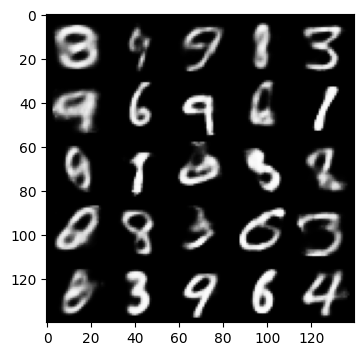

In [13]:
import matplotlib.pyplot as plt

# amostra da distribuição latente normal padrão
n = 5  # 15x15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Gerar digitos
for i in range(n):
  for j in range(n):
    z_sample = np.random.normal(size=(1, latent_dim)) * epsilon_std
    x_decoded = generator.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size ] = digit

plt.figure(figsize=(4, 4))
plt.imshow(figure, cmap='Greys_r')
plt.show()